# Exploratory notebook to characterize mixing in terms of salinity coordinates. 
The goal of this analysis is to get an understanding of how numerical mixing influences the larger-scale salinity structure and flow. Here, we use the analysis presented in Hennel et al. (*submitted*). Their section 2.1 is paraphrased below.
### The volume-integrated mixing in a 3D control volume with with salinities $s>S$ may be calculated as
$M(s) = \int_{V(s)} \chi^s \, dV$, $\chi^s = 2 \kappa_V \left(\frac{\partial s}{\partial z} \right)^2 \, ,$ where
> - $V(s)$ is a volume including all salinities $s \geq S$
> - $\kappa_v$ is the vertical salinity diffusivity 
> - Units are (g/kg)$^2$ m$^3$/s
### The mixing per salinity class may be calculated as 
$m(s) = \frac{\partial M}{\partial s} \,$, which has units of (g/kg) m$^3$/s.

The integrated diahaline diffusive salt flux is directly proportional to the $m(s)$: 

$J_{dia} = -\frac{1}{2} m(s)$, which has the same units of $m(s)$.

By differentiating in salinity coordinates again, we obtain an expression for the integrated diahaline volume transport:

$Q_{dia} = \frac{1}{2} \frac{\partial m(s)}{\partial s}$, which has units of m$^3$/s.
 
So, once we have an expression for the volume-integrated mixing we should be able to calculate each of these quantities with a simple ```.diff()```. 
> - Dimensional analysis can be used to build intuition. 
> - If we know the diahaline volume transport, taking the integral in salinity coordinates of this yields the diahaline diffusive salt flux, which is directly proportional to the mixing per salinity class.
> - You can calculate these quantites locally with xhistogram, just preserve the lateral dimensions

### Let's be creative - apply this in the coastal ocean for shelfstrat. 
We know from earlier sections of the paper that numerical mixing dominates in the top 1 m of the water column. The isohalines should be vertical here. So if I do the salinity coordinate analysis, the diahaline fluxes should be all lateral. 
> - Calculate $m(s)$, $J_{dia}$, and $Q_{dia}$ locally and integrated over the top 1 of the domain
> - Decompose into physical, numerical, and total contributions
> > - This can tell us exactly how much water is being advected across isohalines due to numerical mixing!!!! 
> - Compare the results for three tracer advection schemes: MPDATA, U3HC4, and HSIMT.
> - Known issues 
> > - Salinity space plots are very noisy, how to optimize the # of bins? 
> > - Sign convention... how to reason out the direction of the fluxes 
> > - This works outside of estuaries... right???

In [1]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime
import glob
from xhistogram.xarray import histogram
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from datetime import timedelta
import warnings
warnings.simplefilter("ignore") # Because I'm chaotic 
import time

### Open model output. Average files due to numerical mixing 

In [2]:
def open_roms(path):
    ds1 = xroms.open_netcdf(path)
    ds1, grid1 = xroms.roms_dataset(ds1)
    return ds1, grid1

paths = ['/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_mpdata_uwind_osc_1/shelf_dx_500_mpdata_uwind_osc_1_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_u3hc4_uwind_osc_1/shelf_dx_500_u3hc4_uwind_osc_1_avg.nc', 
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_hsimt_uwind_osc_1/shelf_dx_500_hsimt_uwind_osc_1_avg.nc']
 
ds = []
grid = []
for i in range(len(paths)):
    ds1, grid1 = open_roms(paths[i])
    ds.append(ds1)
    grid.append(grid1)

xislice = slice(1,-1) #Exclude boundary points bc periodic BC
etaslice = slice(1,100) # Initially stratified region
tslice = slice(156,337) # Days 7.5-15 

### Plot cross-sections of along-shore averaged salinity profiles
This will let us qualitatively look at the isohaline orientation 

In [3]:
smean = ds[0].salt.mean('xi_rho').load()
z_rho = ds[0].z_rho.mean('xi_rho').load() # For plotting
y_rho = ds[0].y_rho # For plotting
smean = smean.assign_coords({'z_rho':z_rho, 'y_rho':ds[0].y_rho[:,0]/1000})
s = ds[0].salt.mean('xi_rho').load()

Text(1, -19, 'Day 15')

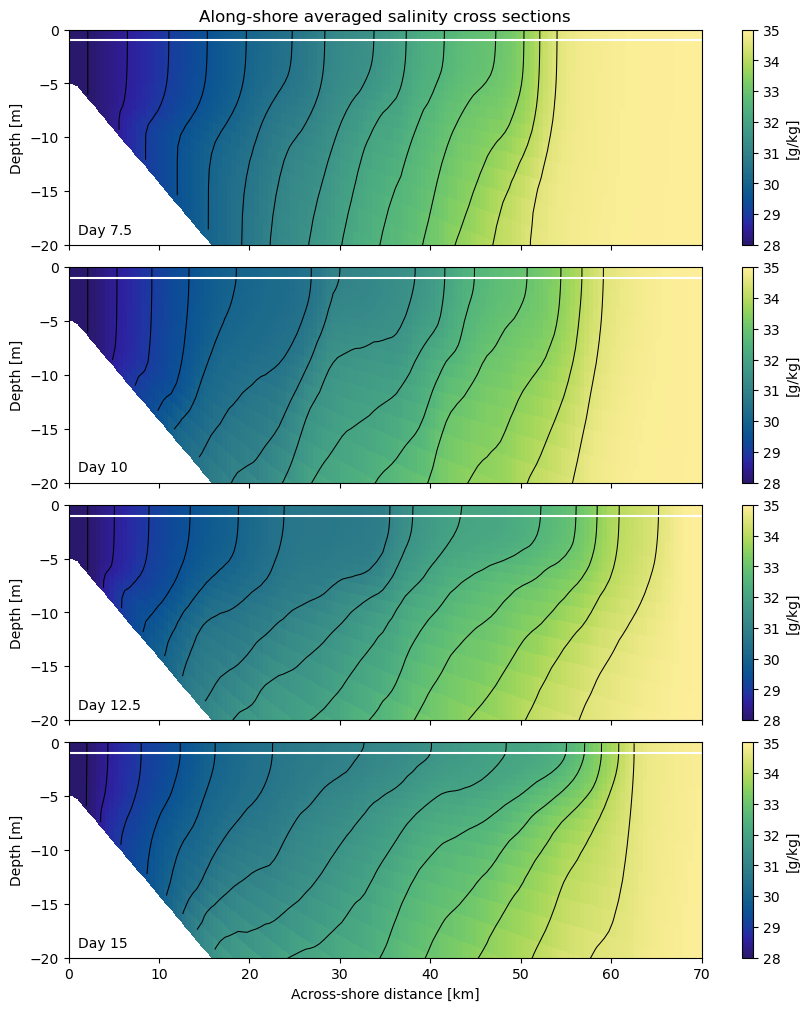

In [4]:
# 115,216,276,336
fig, ax = plt.subplots(4,1, figsize = (8,10), constrained_layout = True)

m1 = ax[0].pcolormesh(y_rho[:194,:30].T/1000,z_rho[115],s[115], vmin = 28, vmax = 35, cmap = cmo.haline)
c1 = ax[0].contour(y_rho[:194,:30].T/1000,z_rho[115],s[115], colors = 'k', linewidths = 0.75, levels = np.arange(28,36,0.5))
fig.colorbar(m1, ax = ax[0], label = '[g/kg]')
# ax[0].clabel(c1, inline=True, fmt='%d')

m2 = ax[1].pcolormesh(y_rho[:194,:30].T/1000,z_rho[115],s[216], vmin = 28, vmax = 35, cmap = cmo.haline)
ax[1].contour(y_rho[:194,:30].T/1000,z_rho[115],s[216], colors = 'k', linewidths = 0.75, levels = np.arange(28,36,0.5))
fig.colorbar(m2, ax = ax[1], label = '[g/kg]')

m3 = ax[2].pcolormesh(y_rho[:194,:30].T/1000,z_rho[115],s[276], vmin = 28, vmax = 35, cmap = cmo.haline)
ax[2].contour(y_rho[:194,:30].T/1000,z_rho[115],s[276], colors = 'k', linewidths = 0.75, levels = np.arange(28,36,0.5))
fig.colorbar(m3, ax = ax[2], label = '[g/kg]')

m4 = ax[3].pcolormesh(y_rho[:194,:30].T/1000,z_rho[115],s[336], vmin = 28, vmax = 35, cmap = cmo.haline)
ax[3].contour(y_rho[:194,:30].T/1000,z_rho[115],s[336], colors = 'k', linewidths = 0.75, levels = np.arange(28,36,0.5))
fig.colorbar(m4, ax = ax[3], label = '[g/kg]')

for i in range(4):
    ax[i].set_ylim(-20,0)
    ax[i].set_xlim(0,70)
    ax[i].axhline(-1, c='white')
    ax[i].set_ylabel('Depth [m]')
    
for i in range(3):
    ax[i].set_xlabel('')
    ax[i].set_xticklabels([])
    
ax[0].set_title('Along-shore averaged salinity cross sections')
ax[3].set_xlabel('Across-shore distance [km]')
ax[0].text(1, -19, 'Day 7.5')
ax[1].text(1, -19, 'Day 10')
ax[2].text(1, -19, 'Day 12.5')
ax[3].text(1, -19, 'Day 15')

#### Zoom in more 

Text(61, -9, 'Day 15')

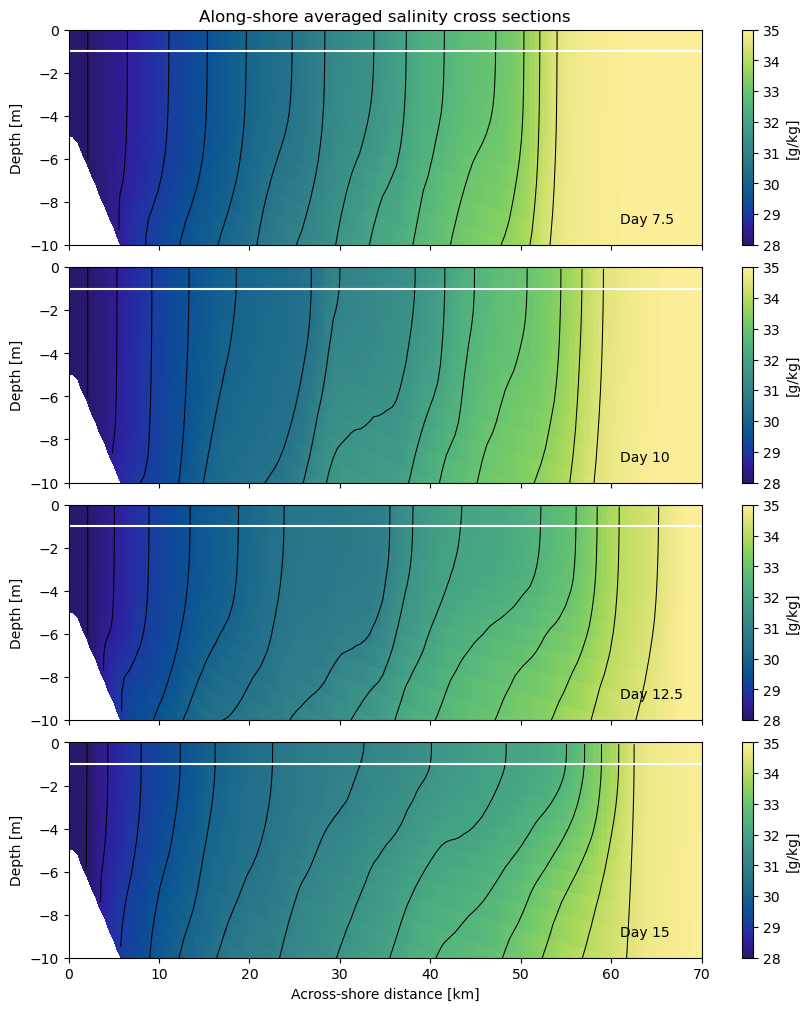

In [5]:
fig, ax = plt.subplots(4,1, figsize = (8,10), constrained_layout = True)

m1 = ax[0].pcolormesh(y_rho[:194,:30].T/1000,z_rho[115],s[115], vmin = 28, vmax = 35, cmap = cmo.haline)
c1 = ax[0].contour(y_rho[:194,:30].T/1000,z_rho[115],s[115], colors = 'k', linewidths = 0.75, levels = np.arange(28,36,0.5))
fig.colorbar(m1, ax = ax[0], label = '[g/kg]')
# ax[0].clabel(c1, inline=True, fmt='%d')

m2 = ax[1].pcolormesh(y_rho[:194,:30].T/1000,z_rho[115],s[216], vmin = 28, vmax = 35, cmap = cmo.haline)
ax[1].contour(y_rho[:194,:30].T/1000,z_rho[115],s[216], colors = 'k', linewidths = 0.75, levels = np.arange(28,36,0.5))
fig.colorbar(m2, ax = ax[1], label = '[g/kg]')

m3 = ax[2].pcolormesh(y_rho[:194,:30].T/1000,z_rho[115],s[276], vmin = 28, vmax = 35, cmap = cmo.haline)
ax[2].contour(y_rho[:194,:30].T/1000,z_rho[115],s[276], colors = 'k', linewidths = 0.75, levels = np.arange(28,36,0.5))
fig.colorbar(m3, ax = ax[2], label = '[g/kg]')

m4 = ax[3].pcolormesh(y_rho[:194,:30].T/1000,z_rho[115],s[336], vmin = 28, vmax = 35, cmap = cmo.haline)
ax[3].contour(y_rho[:194,:30].T/1000,z_rho[115],s[336], colors = 'k', linewidths = 0.75, levels = np.arange(28,36,0.5))
fig.colorbar(m4, ax = ax[3], label = '[g/kg]')

for i in range(4):
    ax[i].set_ylim(-10,0)
    ax[i].set_xlim(0,70)
    ax[i].axhline(-1, c='white')
    ax[i].set_ylabel('Depth [m]')
    
for i in range(3):
    ax[i].set_xlabel('')
    ax[i].set_xticklabels([])
    
ax[0].set_title('Along-shore averaged salinity cross sections')
ax[3].set_xlabel('Across-shore distance [km]')
ax[0].text(61, -9, 'Day 7.5')
ax[1].text(61, -9, 'Day 10')
ax[2].text(61, -9, 'Day 12.5')
ax[3].text(61, -9, 'Day 15')

### The isohalines are vertical in the top 1 m of the water column. Shouldn't be a big deal. 
Figure out how to quantify the uncertainity later.

### Calculate $M(s)$, the volume-integrated mixing in salinity coordinates. 
Do this over the top 1 m for the *entire* domain, not just the initially stratified region. Why?
> - Numerical mixing happens at the fronts. We see it in the depth-integrated plots (2023 GRC poster).
> - If I use the initially stratified region, that doesn't tell me how numerical mixing is changing the fronts at Day 15 because they are advected past the 50 m isobath, which is the boundary of the initial region

In [6]:
def mixing_scoord_1m(ds,tslice,grid):
    '''
Notes: 
------
Remove the first and last boundary points. The -1 eta_rho point has massive numerical mixing due 
the offshore B.C. . Also, remove the [0,-1] along-shore points due to the periodic B.C.
    '''
    salt = ds.salt.where(ds.z_rho>-1).isel(ocean_time = tslice, xi_rho = slice(1,-1), eta_rho = slice(1,-1))
    dv = ds.dV.where(ds.z_rho>-1).isel(ocean_time = tslice, xi_rho = slice(1,-1), eta_rho = slice(1,-1))

    akr = grid.interp(ds.AKr,'Z')
    mphy = ((akr*ds.dV).where(ds.z_rho>-1).isel(ocean_time = tslice, xi_rho = slice(1,-1), eta_rho = slice(1,-1)))
    mphy = mphy.fillna(0)
    mphy.attrs = ''
    mnum = ((ds.dye_03*ds.dV).where(ds.z_rho>-1).isel(ocean_time = tslice, xi_rho = slice(1,-1), eta_rho = slice(1,-1)))
    mnum = mnum.fillna(0)
    mnum.attrs = ''
    mtot = (((ds.dye_03+akr)*ds.dV).where(ds.z_rho>-1).isel(ocean_time = tslice, xi_rho = slice(1,-1), eta_rho = slice(1,-1)))
    mtot = mtot.fillna(0)
    mtot.attrs = ''
    
    sbins = np.arange(26.9,35.1,0.2)
    
    # Compute M(S), m(S), J_dia(S), and Q_dia(S)
    Mnum_s = histogram(salt, bins = [sbins], weights = mnum) #'dim=[]' just adds salinity as a coordinate but doesn't bin
    Mnum_s.attrs = ''
    Mnum_s.name = 'Mnum'
    Mphy_s = histogram(salt, bins = [sbins], weights = mphy) #'dim=[]' just adds salinity as a coordinate but doesn't bin
    Mphy_s.attrs = ''
    Mphy_s.name = 'Mphy'
    Mtot_s = histogram(salt, bins = [sbins], weights = mtot) #'dim=[]' just adds salinity as a coordinate but doesn't bin
    Mtot_s.attrs = ''
    Mtot_s.name = 'Mtot'  
    
    dsalt = (Mnum_s.salt_bin[1]-Mnum_s.salt_bin[0]).values

    mnum_s = Mnum_s.diff('salt_bin')/dsalt
    mnum_s.attrs = ''
    mnum_s.name = 'mnum'
    mphy_s = Mphy_s.diff('salt_bin')/dsalt
    mphy_s.attrs = ''
    mphy_s.name = 'mphy'
    mtot_s = Mtot_s.diff('salt_bin')/dsalt
    mtot_s.attrs = ''
    mtot_s.name = 'mtot'

    Jdia_num = -0.5*(mnum_s)
    Jdia_num.attrs = ''
    Jdia_num.name = 'jdia_mnum'
    Jdia_phy = -0.5*(mphy_s)
    Jdia_phy.attrs = ''
    Jdia_phy.name = 'jdia_mphy'
    Jdia_tot = -0.5*(mtot_s)
    Jdia_tot.attrs = ''
    Jdia_tot.name = 'jdia_mtot'

    Qdia_num = 0.5*(mnum_s.diff('salt_bin')/dsalt)
    Qdia_num.attrs = ''
    Qdia_num.name = 'Qdia_num'
    Qdia_phy = 0.5*(mphy_s.diff('salt_bin')/dsalt)
    Qdia_phy.attrs = ''
    Qdia_phy.name = 'Qdia_phy'
    Qdia_tot = 0.5*(mtot_s.diff('salt_bin')/dsalt)
    Qdia_tot.attrs = ''
    Qdia_tot.name = 'Qdia_tot'
    
    dsl = xr.merge([Mnum_s,Mphy_s,Mtot_s,mnum_s ,mphy_s ,mtot_s, Jdia_num, Jdia_phy, Jdia_tot, Qdia_num, Qdia_phy, Qdia_tot], compat = 'override')
    dsl.salt_bin.attrs = ''
    
    return dsl

xislice = slice(1,-1) #Exclude boundary points bc periodic BC
# etaslice = slice(1,100) # Initially stratified region
etaslice = slice(1,-1)
tslice = slice(156,337) # Days 7.5-15 

dsm_mpd = mixing_scoord_1m(ds[0],tslice,grid[0])
dsm_u3h = mixing_scoord_1m(ds[1],tslice,grid[1])
dsm_hsi = mixing_scoord_1m(ds[2],tslice,grid[2])

# dsm_mpd.to_netcdf('vint_mix1_top1m_mpdata_shelf_dx_500_uwind_osc_1.nc')
# dsm_u3h.to_netcdf('vint_mix1_top1m_u3hc4_shelf_dx_500_uwind_osc_1.nc')
# dsm_hsi.to_netcdf('vint_mix1_top1m_hsimt_shelf_dx_500_uwind_osc_1.nc')

### Open the integrated histograms and plot the various quantities separately in this order: $M(s)$, $m(s)$, $J_{dia}(s)$, and $Q_{dia}(s)$
Then combine them into a mega plot to see how it looks 

In [7]:
mpd = xr.open_dataset('vint_mix1_top1m_mpdata_shelf_dx_500_uwind_osc_1.nc')
u3h = xr.open_dataset('vint_mix1_top1m_u3hc4_shelf_dx_500_uwind_osc_1.nc')
hsi = xr.open_dataset('vint_mix1_top1m_hsimt_shelf_dx_500_uwind_osc_1.nc')
mpd

<xarray.Dataset>
Dimensions:    (salt_bin: 41)
Coordinates:
  * salt_bin   (salt_bin) float64 27.0 27.2 27.4 27.6 ... 34.4 34.6 34.8 35.0
Data variables:
    Mnum       (salt_bin) float64 ...
    Mphy       (salt_bin) float64 ...
    Mtot       (salt_bin) float64 ...
    mnum       (salt_bin) float64 ...
    mphy       (salt_bin) float64 ...
    mtot       (salt_bin) float64 ...
    jdia_mnum  (salt_bin) float64 ...
    jdia_mphy  (salt_bin) float64 ...
    jdia_mtot  (salt_bin) float64 ...
    Qdia_num   (salt_bin) float64 ...
    Qdia_phy   (salt_bin) float64 ...
    Qdia_tot   (salt_bin) float64 ...

Text(0.5, 0, '')

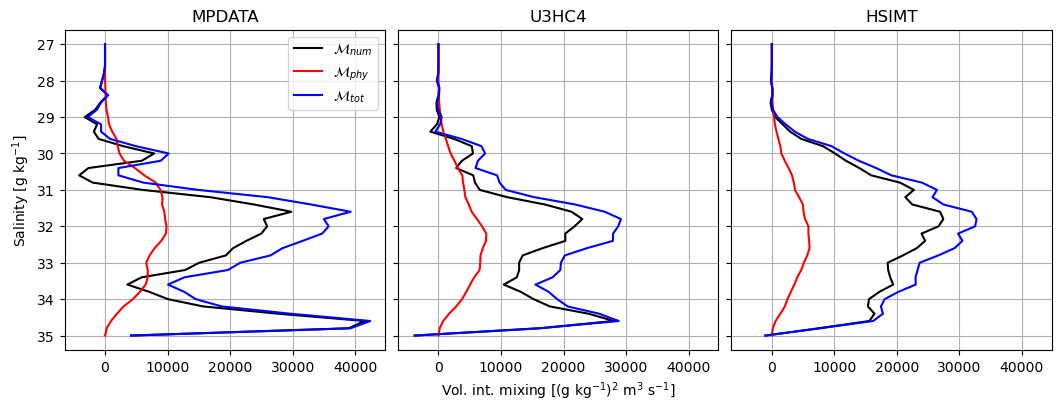

In [8]:
fig, ax = plt.subplots(1,3, figsize = (3.5*3,4), sharex = True, sharey= True, constrained_layout = True)

(mpd.Mnum).plot(ax = ax[0], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(mpd.Mphy).plot(ax = ax[0], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(mpd.Mtot).plot(ax = ax[0], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

(u3h.Mnum).plot(ax = ax[1], y = 'salt_bin', c = 'k', label = r'')
(u3h.Mphy).plot(ax = ax[1], y = 'salt_bin', c = 'r', label = r'')
(u3h.Mtot).plot(ax = ax[1], y = 'salt_bin', c = 'b', label = r'')

(hsi.Mnum).plot(ax = ax[2], y = 'salt_bin', c = 'k', label = r'')
(hsi.Mphy).plot(ax = ax[2], y = 'salt_bin', c = 'r', label = r'')
(hsi.Mtot).plot(ax = ax[2], y = 'salt_bin', c = 'b', label = r'')

ax[0].set_title(r'MPDATA')
ax[1].set_title(r'U3HC4')
ax[2].set_title(r'HSIMT')

ax[0].set_xlabel(r'')
ax[0].set_ylabel('Salinity [g kg$^{-1}$]')
ax[0].legend()

for i in range(3):
    ax[i].grid(which = 'both')
    plt.gca().invert_yaxis()
    
ax[1].set_ylabel('')
ax[1].set_xlabel('Vol. int. mixing [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}$]')
ax[2].set_ylabel('')
ax[2].set_xlabel('')

In [9]:
print('Numerical mixing, MPDATA/HSIMT: ', mpd.Mnum.sum().values/hsi.Mnum.sum().values)
print('Numerical mixing, U3HC4/HSIMT: ', u3h.Mnum.sum().values/hsi.Mnum.sum().values)
print('Numerical mixing, U3HC4/MPDATA: ', u3h.Mnum.sum().values/mpd.Mnum.sum().values)

print('Physical mixing, MPDATA/HSIMT: ', mpd.Mphy.sum().values/hsi.Mphy.sum().values)
print('Physical mixing, U3HC4/HSIMT: ', u3h.Mphy.sum().values/hsi.Mphy.sum().values)
print('Physical mixing, U3HC4/MPDATA: ', u3h.Mphy.sum().values/mpd.Mphy.sum().values)

Numerical mixing, MPDATA/HSIMT:  0.8021428431108989
Numerical mixing, U3HC4/HSIMT:  0.7312187612561714
Numerical mixing, U3HC4/MPDATA:  0.911581730780434
Physical mixing, MPDATA/HSIMT:  1.6833698655490414
Physical mixing, U3HC4/HSIMT:  1.220678400541005
Physical mixing, U3HC4/MPDATA:  0.7251397482649324


### First - let's recap what we're seeing here. 
The structure is much more complex than a two-layer estuary, as expected. Key points: 
> - Numerical mixing clearly dominates in the top 1 m. 
> - MPDATA no longer has the weakest numerical mixing compared to the entire water of the initially stratified region!! U3HC4 does. HSIMT is still the worst. 
> > - For the entire water column, MPDATA has the most physical mixing, least numerical mixing, and weakest total mixing. 
> - HSIMT has the weakest physical mixing by a landslide, consistent with volume-integrated results over the initially stratified region.
> - There are two peaks: one at intermediate salinities, other corresponding to the offshore boundary 

Text(0.5, 0, '')

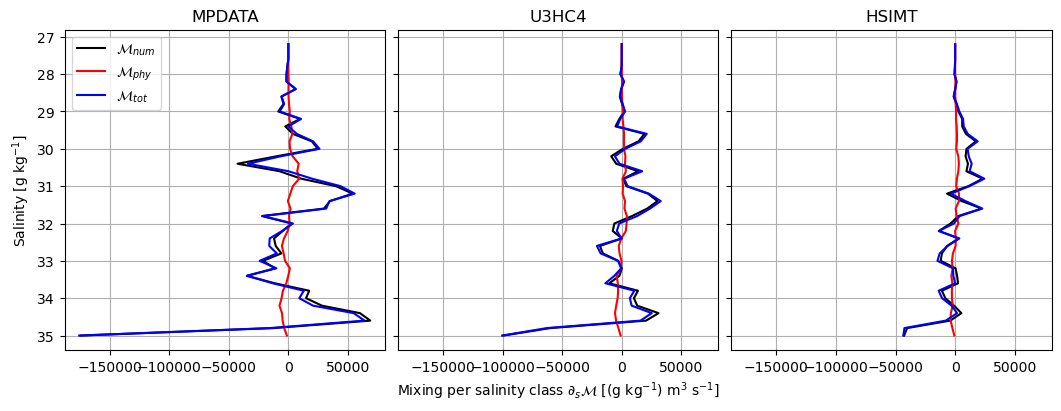

In [10]:
fig, ax = plt.subplots(1,3, figsize = (3.5*3,4), sharex = True, sharey= True, constrained_layout = True)

(mpd.mnum).plot(ax = ax[0], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(mpd.mphy).plot(ax = ax[0], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(mpd.mtot).plot(ax = ax[0], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

(u3h.mnum).plot(ax = ax[1], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(u3h.mphy).plot(ax = ax[1], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(u3h.mtot).plot(ax = ax[1], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

(hsi.mnum).plot(ax = ax[2], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(hsi.mphy).plot(ax = ax[2], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(hsi.mtot).plot(ax = ax[2], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

ax[0].set_title(r'MPDATA')
ax[1].set_title(r'U3HC4')
ax[2].set_title(r'HSIMT')

ax[0].set_xlabel(r'')
ax[0].set_ylabel('Salinity [g kg$^{-1}$]')
ax[0].legend()

for i in range(3):
    ax[i].grid(which = 'both')
    plt.gca().invert_yaxis()
    
ax[1].set_ylabel('')
ax[1].set_xlabel(r'Mixing per salinity class $\partial_s \mathcal{M}$ [(g kg$^{-1}$) m$^3$ s$^{-1}$]')
ax[2].set_ylabel('')
ax[2].set_xlabel('')

Text(0.5, 0, '')

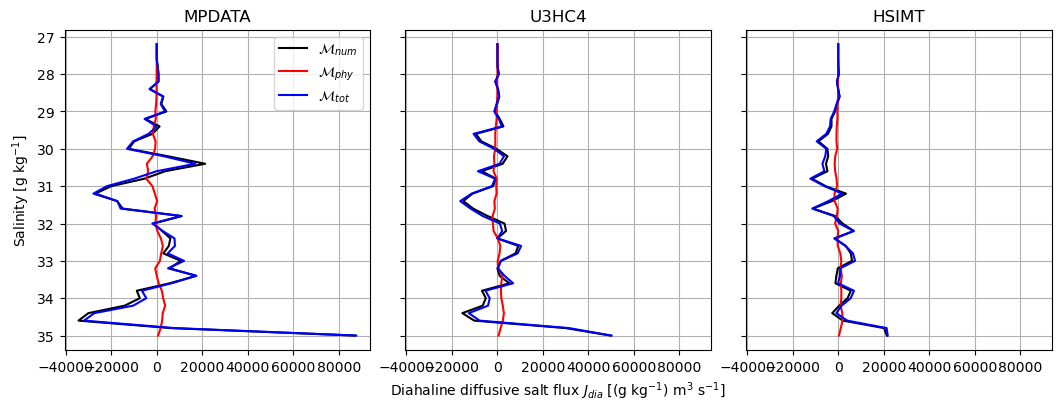

In [11]:
fig, ax = plt.subplots(1,3, figsize = (3.5*3,4), sharex = True, sharey= True, constrained_layout = True)

(mpd.jdia_mnum).plot(ax = ax[0], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(mpd.jdia_mphy).plot(ax = ax[0], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(mpd.jdia_mtot).plot(ax = ax[0], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

(u3h.jdia_mnum).plot(ax = ax[1], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(u3h.jdia_mphy).plot(ax = ax[1], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(u3h.jdia_mtot).plot(ax = ax[1], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

(hsi.jdia_mnum).plot(ax = ax[2], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(hsi.jdia_mphy).plot(ax = ax[2], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(hsi.jdia_mtot).plot(ax = ax[2], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

ax[0].set_title(r'MPDATA')
ax[1].set_title(r'U3HC4')
ax[2].set_title(r'HSIMT')

ax[0].set_xlabel(r'')
ax[0].set_ylabel('Salinity [g kg$^{-1}$]')
ax[0].legend()

for i in range(3):
    ax[i].grid(which = 'both')
    plt.gca().invert_yaxis()
    
ax[1].set_ylabel('')
ax[1].set_xlabel(r'Diahaline diffusive salt flux $J_{dia}$ [(g kg$^{-1}$) m$^3$ s$^{-1}$]')
ax[2].set_ylabel('')
ax[2].set_xlabel('')

In [12]:
print('Numerical / total diahaline diffusive salt flux: MPDATA', mpd.jdia_mnum.sum().values/(mpd.jdia_mtot.sum().values))
print('Numerical / total diahaline diffusive salt flux: U3HC4', u3h.jdia_mnum.sum().values/(u3h.jdia_mtot.sum().values))
print('Numerical / total diahaline diffusive salt flux: HSIMT', hsi.jdia_mnum.sum().values/(hsi.jdia_mtot.sum().values))

print('Diahaline numerical diffusive salt flux, MPDATA/HSIMT: ', mpd.jdia_mnum.sum().values/(hsi.jdia_mnum.sum().values))
print('Diahaline numerical diffusive salt flux, U3HC4/HSIMT: ', u3h.jdia_mnum.sum().values/(hsi.jdia_mnum.sum().values))
print('Diahaline numerical diffusive salt flux, U3HC4/MPDATA: ', u3h.jdia_mnum.sum().values/(mpd.jdia_mnum.sum().values))

print('Diahaline physical diffusive salt flux, MPDATA/HSIMT: ', mpd.jdia_mphy.sum().values/(hsi.jdia_mphy.sum().values))
print('Diahaline physical diffusive salt flux, U3HC4/HSIMT: ', u3h.jdia_mphy.sum().values/(hsi.jdia_mphy.sum().values))
print('Diahaline physical diffusive salt flux, U3HC4/MPDATA: ', u3h.jdia_mphy.sum().values/(mpd.jdia_mphy.sum().values))

print('Diahaline total diffusive salt flux, MPDATA/HSIMT: ', mpd.jdia_mtot.sum().values/(hsi.jdia_mtot.sum().values))
print('Diahaline total diffusive salt flux, U3HC4/HSIMT: ', u3h.jdia_mtot.sum().values/(hsi.jdia_mtot.sum().values))
print('Diahaline total diffusive salt flux, U3HC4/MPDATA: ', u3h.jdia_mtot.sum().values/(mpd.jdia_mtot.sum().values))

print('Diahaline total diffusive salt flux, MPDATA/HSIMT: ', mpd.jdia_mtot.sum().values/(hsi.jdia_mtot.sum().values))
print('Diahaline total diffusive salt flux, U3HC4/HSIMT: ', u3h.jdia_mtot.sum().values/(hsi.jdia_mtot.sum().values))
print('Diahaline total diffusive salt flux, U3HC4/MPDATA: ', u3h.jdia_mtot.sum().values/(mpd.jdia_mtot.sum().values))

Numerical / total diahaline diffusive salt flux: MPDATA 0.9967568590661552
Numerical / total diahaline diffusive salt flux: U3HC4 1.0028170347052867
Numerical / total diahaline diffusive salt flux: HSIMT 1.0051036902259207
Diahaline numerical diffusive salt flux, MPDATA/HSIMT:  -4.070266113220059
Diahaline numerical diffusive salt flux, U3HC4/HSIMT:  3.7142661288713987
Diahaline numerical diffusive salt flux, U3HC4/MPDATA:  -0.9125364351012856
Diahaline physical diffusive salt flux, MPDATA/HSIMT:  2.6081109502549955
Diahaline physical diffusive salt flux, U3HC4/HSIMT:  2.054802583074302
Diahaline physical diffusive salt flux, U3HC4/MPDATA:  0.7878509090548483
Diahaline total diffusive salt flux, MPDATA/HSIMT:  -4.104350477639877
Diahaline total diffusive salt flux, U3HC4/HSIMT:  3.722735517458504
Diahaline total diffusive salt flux, U3HC4/MPDATA:  -0.9070218388365282
Diahaline total diffusive salt flux, MPDATA/HSIMT:  -4.104350477639877
Diahaline total diffusive salt flux, U3HC4/HSIMT:

Text(0.5, 0, '')

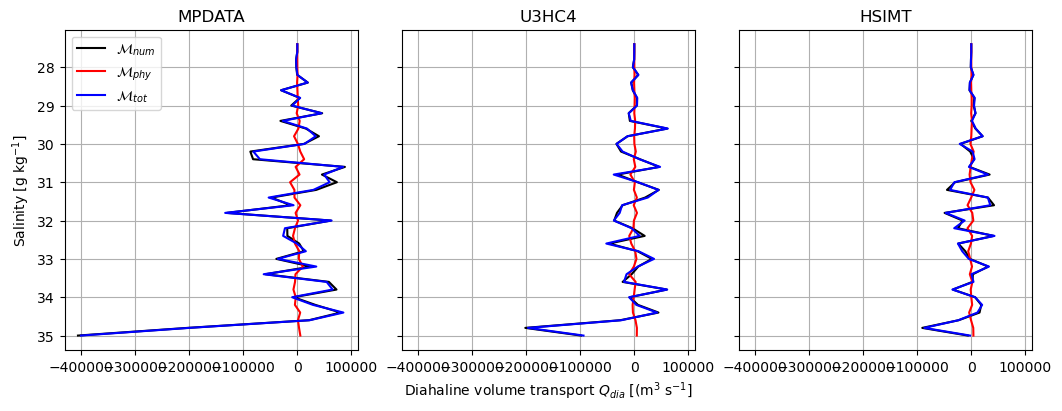

In [13]:
fig, ax = plt.subplots(1,3, figsize = (3.5*3,4), sharex = True, sharey= True, constrained_layout = True)

(mpd.Qdia_num).plot(ax = ax[0], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(mpd.Qdia_phy).plot(ax = ax[0], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(mpd.Qdia_tot).plot(ax = ax[0], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

(u3h.Qdia_num).plot(ax = ax[1], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(u3h.Qdia_phy).plot(ax = ax[1], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(u3h.Qdia_tot).plot(ax = ax[1], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

(hsi.Qdia_num).plot(ax = ax[2], y = 'salt_bin', c = 'k', label = r'$\mathcal{M}_{num}$')
(hsi.Qdia_phy).plot(ax = ax[2], y = 'salt_bin', c = 'r', label = r'$\mathcal{M}_{phy}$')
(hsi.Qdia_tot).plot(ax = ax[2], y = 'salt_bin', c = 'b', label = r'$\mathcal{M}_{tot}$')

ax[0].set_title(r'MPDATA')
ax[1].set_title(r'U3HC4')
ax[2].set_title(r'HSIMT')

ax[0].set_xlabel(r'')
ax[0].set_ylabel('Salinity [g kg$^{-1}$]')
ax[0].legend()

for i in range(3):
    ax[i].grid(which = 'both')
    plt.gca().invert_yaxis()
    
ax[1].set_ylabel('')
ax[1].set_xlabel(r'Diahaline volume transport $Q_{dia}$ [(m$^3$ s$^{-1}$]')
ax[2].set_ylabel('')
ax[2].set_xlabel('')

In [14]:
print('Numerical / total diahaline volume flux: MPDATA', mpd.Qdia_num.sum().values/(mpd.Qdia_tot.sum().values))
print('Numerical / total diahaline volume flux: U3HC4', u3h.Qdia_num.sum().values/(u3h.Qdia_tot.sum().values))
print('Numerical / total diahaline volume flux: HSIMT', hsi.Qdia_num.sum().values/(hsi.Qdia_tot.sum().values))

print('Diahaline numerical volume flux, MPDATA/HSIMT: ', mpd.Qdia_num.sum().values/(hsi.Qdia_num.sum().values))
print('Diahaline numerical volume flux, U3HC4/HSIMT: ', u3h.Qdia_num.sum().values/(hsi.Qdia_num.sum().values))
print('Diahaline numerical volume flux, U3HC4/MPDATA: ', u3h.Qdia_num.sum().values/(mpd.Qdia_num.sum().values))

print('Diahaline physical volume flux, MPDATA/HSIMT: ', mpd.Qdia_phy.sum().values/(hsi.Qdia_phy.sum().values))
print('Diahaline physical volume flux, U3HC4/HSIMT: ', u3h.Qdia_phy.sum().values/(hsi.Qdia_phy.sum().values))
print('Diahaline physical volume flux, U3HC4/MPDATA: ', u3h.Qdia_phy.sum().values/(mpd.Qdia_phy.sum().values))

print('Diahaline total volume flux, MPDATA/HSIMT: ', mpd.Qdia_tot.sum().values/(hsi.Qdia_tot.sum().values))
print('Diahaline total volume flux, U3HC4/HSIMT: ', u3h.Qdia_tot.sum().values/(hsi.Qdia_tot.sum().values))
print('Diahaline total volume flux, U3HC4/MPDATA: ', u3h.Qdia_tot.sum().values/(mpd.Qdia_tot.sum().values))

Numerical / total diahaline volume flux: MPDATA 0.9929424033576765
Numerical / total diahaline volume flux: U3HC4 0.9905698263004397
Numerical / total diahaline volume flux: HSIMT 0.9839029864981577
Diahaline numerical volume flux, MPDATA/HSIMT:  4.070126026943401
Diahaline numerical volume flux, U3HC4/HSIMT:  2.3210567456276556
Diahaline numerical volume flux, U3HC4/MPDATA:  0.5702665544660619
Diahaline physical volume flux, MPDATA/HSIMT:  1.768266045476676
Diahaline physical volume flux, U3HC4/HSIMT:  1.3506017582630143
Diahaline physical volume flux, U3HC4/MPDATA:  0.7638000863715781
Diahaline total volume flux, MPDATA/HSIMT:  4.033072955482353
Diahaline total volume flux, U3HC4/HSIMT:  2.3054353193695007
Diahaline total volume flux, U3HC4/MPDATA:  0.5716324363127651


### If these calculations are correct - numerical mixing solely drives diahaline volume transport in the top 1 m of the water column.
### Since the diahaline volume/salt transport is a lateral flux, this makes intuitive sense because NO explicit lateral mixing is applied in our simulations.


These are noisy, but let's compare to Hennel et al's results for the Baltic Sea to build intuition. See below

![hennel_etal_fig6.png](hennel_etal_fig6.png)

### We're comparing to their thin black line and the thick black line. 
Their residual is still noisy, but it almost exclusively two layer. Why is shelfstrat more complex?
> - Wind and eddies are sloshing the water back and forth across an isohaline. 

### Repeat the same calculations, but do these locally to retain the $x$ and $y$ dimensions.
Computation time will be slow, lot of calculations here. 
QC check - should I be taking the volume integral over the top 1 m or just the vertical integral? Not sure if the units physically make sense or if it doesn't matter since $dA$ is constant 

In [15]:
def scoord_local(ds,tslice,grid):
    salt = ds.salt.isel(ocean_time = tslice, eta_rho = slice(1,-1)).where(ds.z_rho>-1)
    dv = ds.dV.isel(ocean_time = tslice, eta_rho = slice(1,-1)).where(ds.z_rho>-1)

    akr = grid.interp(ds.AKr,'Z')
    mphy = (akr*ds.dV).isel(ocean_time = tslice, eta_rho = slice(1,-1)).where(ds.z_rho>-1)
    mphy.attrs = ''
    mnum = (ds.dye_03*ds.dV).isel(ocean_time = tslice, eta_rho = slice(1,-1)).where(ds.z_rho>-1)
    mnum.attrs = ''
    mtot = ((ds.dye_03+akr)*ds.dV).isel(ocean_time = tslice, eta_rho = slice(1,-1)).where(ds.z_rho>-1)
    mtot.attrs = ''

    sbins = np.arange(26.9,35.1,0.2)

    # Compute M(S), m(S), J_dia(S), and Q_dia(S)
    Mnum_s = histogram(salt, bins = [sbins], weights = mnum, dim = ['ocean_time','s_rho']).load()
    Mnum_s.attrs = ''
    Mnum_s.name = 'Mnum'
    Mphy_s = histogram(salt, bins = [sbins], weights = mphy, dim = ['ocean_time','s_rho']).load()
    Mphy_s.attrs = ''
    Mphy_s.name = 'Mphy'
    Mtot_s = histogram(salt, bins = [sbins], weights = mtot, dim = ['ocean_time','s_rho']).load()
    Mtot_s.attrs = ''
    Mtot_s.name = 'Mtot'

    dsalt = (Mnum_s.salt_bin[1]-Mnum_s.salt_bin[0]).values

    mnum_s = Mnum_s.diff('salt_bin')/dsalt
    mnum_s.attrs = ''
    mnum_s.name = 'mnum'
    mphy_s = Mphy_s.diff('salt_bin')/dsalt
    mphy_s.attrs = ''
    mphy_s.name = 'mphy'
    mtot_s = Mtot_s.diff('salt_bin')/dsalt
    mtot_s.attrs = ''
    mtot_s.name = 'mtot'

    Jdia_num = -0.5*(mnum_s)
    Jdia_num.attrs = ''
    Jdia_num.name = 'jdia_mnum'
    Jdia_phy = -0.5*(mphy_s)
    Jdia_phy.attrs = ''
    Jdia_phy.name = 'jdia_mphy'
    Jdia_tot = -0.5*(mtot_s)
    Jdia_tot.attrs = ''
    Jdia_tot.name = 'jdia_mtot'

    Qdia_num = 0.5*(mnum_s.diff('salt_bin')/dsalt)
    Qdia_num.attrs = ''
    Qdia_num.name = 'Qdia_num'
    Qdia_phy = 0.5*(mphy_s.diff('salt_bin')/dsalt)
    Qdia_phy.attrs = ''
    Qdia_phy.name = 'Qdia_phy'
    Qdia_tot = 0.5*(mtot_s.diff('salt_bin')/dsalt)
    Qdia_tot.attrs = ''
    Qdia_tot.name = 'Qdia_tot'
    
    dsl = xr.merge([Mnum_s,Mphy_s,Mtot_s,mnum_s ,mphy_s ,mtot_s, Jdia_num, Jdia_phy, Jdia_tot, Qdia_num, Qdia_phy, Qdia_tot], compat = 'override')
        
    return dsl

mpd_l = scoord_local(ds[0],tslice,grid[0])
u3h_l = scoord_local(ds[1],tslice,grid[1])
hsi_l = scoord_local(ds[2],tslice,grid[2])

### Make plan view plots of numerical, physical, and total contribution for the salinity coordinate plots.
MPDATA, U3HC4, and HSIMT

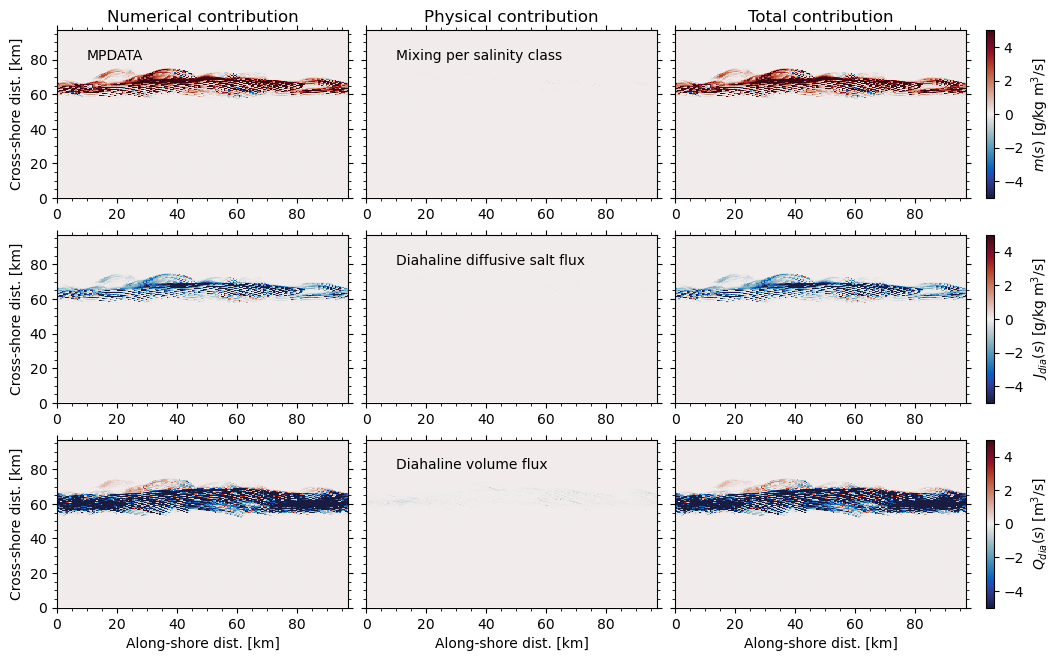

In [16]:
xrho = ds[0].x_rho.isel(eta_rho = slice(1,-1))/1000
yrho = ds[0].y_rho.isel(eta_rho = slice(1,-1))/1000

fig, ax = plt.subplots(3,3, figsize = ((7/2)*3,(8.66/4)*3), constrained_layout=True)

ax[0,0].pcolormesh(xrho, yrho, mpd_l.mnum.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
ax[0,1].pcolormesh(xrho, yrho, mpd_l.mphy.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
m = ax[0,2].pcolormesh(xrho, yrho, mpd_l.mtot.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
fig.colorbar(m, ax = ax[0,2], label = '$m(s)$ [g/kg m$^3$/s]')

ax[1,0].pcolormesh(xrho, yrho, mpd_l.jdia_mnum.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
ax[1,1].pcolormesh(xrho, yrho, mpd_l.jdia_mphy.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
m1 = ax[1,2].pcolormesh(xrho, yrho, mpd_l.jdia_mtot.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
fig.colorbar(m, ax = ax[1,2], label = '$J_{dia}(s)$ [g/kg m$^3$/s]')

ax[2,0].pcolormesh(xrho, yrho, mpd_l.Qdia_num.sum('salt_bin'), cmap=cmo.balance, vmin = -50, vmax = 50)
ax[2,1].pcolormesh(xrho, yrho, mpd_l.Qdia_phy.sum('salt_bin'), cmap=cmo.balance, vmin = -50, vmax = 50)
m2 = ax[2,2].pcolormesh(xrho, yrho, mpd_l.Qdia_tot.sum('salt_bin'), cmap=cmo.balance, vmin = -50, vmax = 50)
fig.colorbar(m, ax = ax[2,2], label = '$Q_{dia}(s)$ [m$^3$/s]')

ax[0,0].set_title('Numerical contribution')
ax[0,1].set_title('Physical contribution')
ax[0,2].set_title('Total contribution')

ax[0,0].text(10,80,'MPDATA')
ax[0,1].text(10,80,'Mixing per salinity class')
ax[1,1].text(10,80,'Diahaline diffusive salt flux')
ax[2,1].text(10,80,'Diahaline volume flux')

for i in range(3):
    for j in range(3):
        ax[i,j].set(xlim=[0,97], ylim=[0,97])
        ax[i,0].set_ylabel('Cross-shore dist. [km]')
        ax[2,j].set_xlabel('Along-shore dist. [km]')
        ax[i,1].set_yticklabels([])
        ax[i,2].set_yticklabels([])
        # ax[i,3].set_yticklabels([])
        ax[i,j].set_xticks(np.arange(0,100,20))
        ax[i,j].minorticks_on()
        ax[i,j].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
        ax[i,j].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)

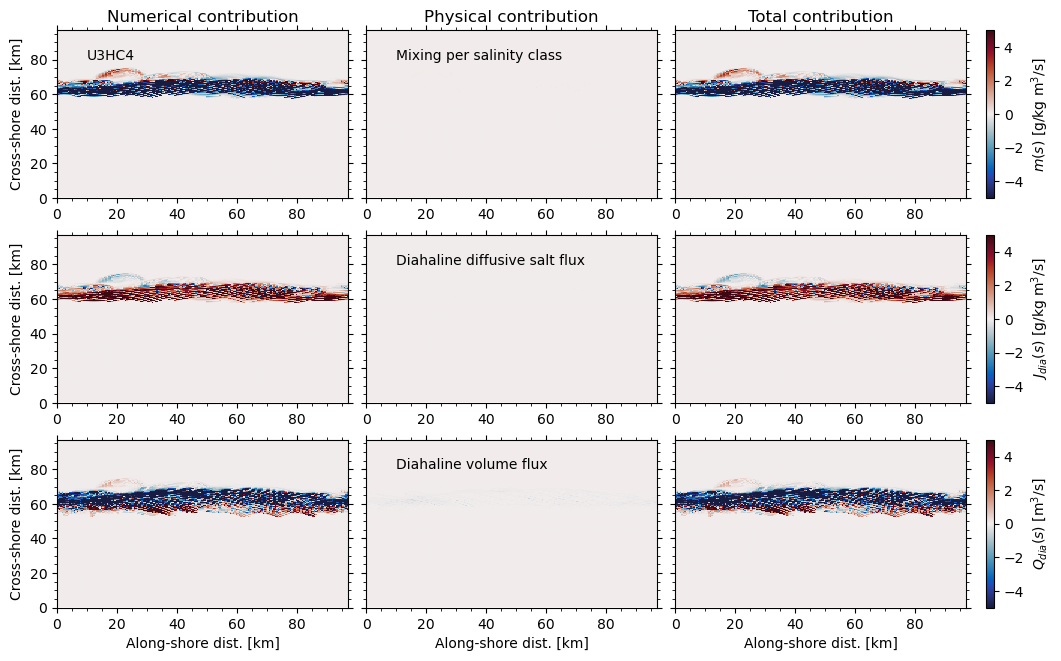

In [17]:
xrho = ds[0].x_rho.isel(eta_rho = slice(1,-1))/1000
yrho = ds[0].y_rho.isel(eta_rho = slice(1,-1))/1000

fig, ax = plt.subplots(3,3, figsize = ((7/2)*3,(8.66/4)*3), constrained_layout=True)

ax[0,0].pcolormesh(xrho, yrho, u3h_l.mnum.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
ax[0,1].pcolormesh(xrho, yrho, u3h_l.mphy.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
m = ax[0,2].pcolormesh(xrho, yrho, u3h_l.mtot.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
fig.colorbar(m, ax = ax[0,2], label = '$m(s)$ [g/kg m$^3$/s]')

ax[1,0].pcolormesh(xrho, yrho, u3h_l.jdia_mnum.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
ax[1,1].pcolormesh(xrho, yrho, u3h_l.jdia_mphy.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
m1 = ax[1,2].pcolormesh(xrho, yrho, u3h_l.jdia_mtot.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
fig.colorbar(m, ax = ax[1,2], label = '$J_{dia}(s)$ [g/kg m$^3$/s]')

ax[2,0].pcolormesh(xrho, yrho, u3h_l.Qdia_num.sum('salt_bin'), cmap=cmo.balance, vmin = -50, vmax = 50)
ax[2,1].pcolormesh(xrho, yrho, u3h_l.Qdia_phy.sum('salt_bin'), cmap=cmo.balance, vmin = -50, vmax = 50)
m2 = ax[2,2].pcolormesh(xrho, yrho, u3h_l.Qdia_tot.sum('salt_bin'), cmap=cmo.balance, vmin = -50, vmax = 50)
fig.colorbar(m, ax = ax[2,2], label = '$Q_{dia}(s)$ [m$^3$/s]')

ax[0,0].set_title('Numerical contribution')
ax[0,1].set_title('Physical contribution')
ax[0,2].set_title('Total contribution')

ax[0,0].text(10,80,'U3HC4')
ax[0,1].text(10,80,'Mixing per salinity class')
ax[1,1].text(10,80,'Diahaline diffusive salt flux')
ax[2,1].text(10,80,'Diahaline volume flux')

for i in range(3):
    for j in range(3):
        ax[i,j].set(xlim=[0,97], ylim=[0,97])
        ax[i,0].set_ylabel('Cross-shore dist. [km]')
        ax[2,j].set_xlabel('Along-shore dist. [km]')
        ax[i,1].set_yticklabels([])
        ax[i,2].set_yticklabels([])
        # ax[i,3].set_yticklabels([])
        ax[i,j].set_xticks(np.arange(0,100,20))
        ax[i,j].minorticks_on()
        ax[i,j].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
        ax[i,j].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)

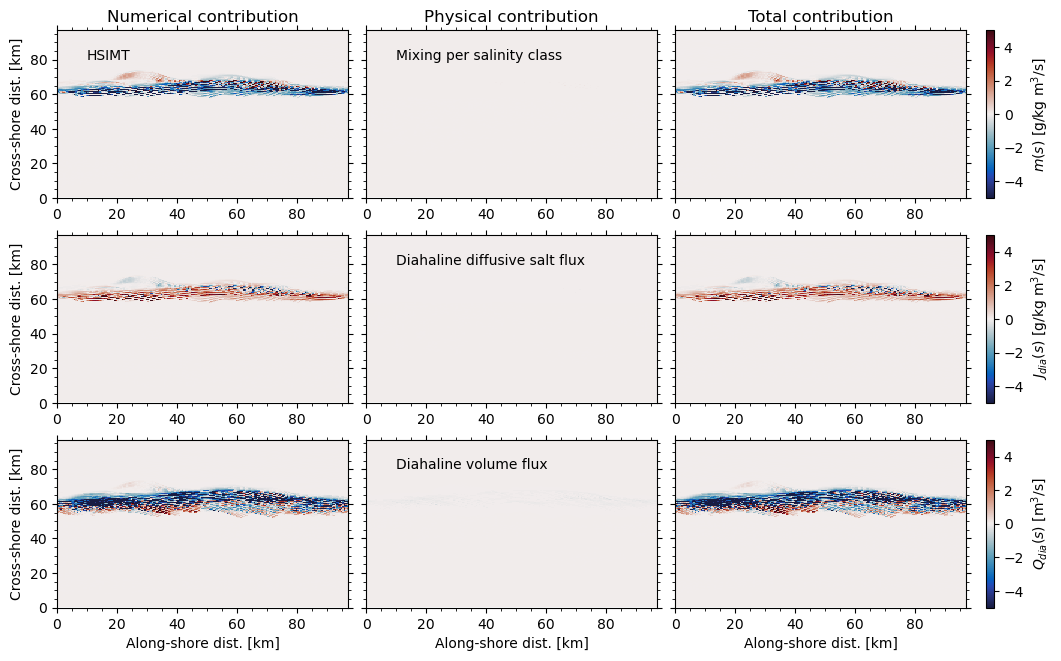

In [18]:
xrho = ds[0].x_rho.isel(eta_rho = slice(1,-1))/1000
yrho = ds[0].y_rho.isel(eta_rho = slice(1,-1))/1000

fig, ax = plt.subplots(3,3, figsize = ((7/2)*3,(8.66/4)*3), constrained_layout=True)

ax[0,0].pcolormesh(xrho, yrho, hsi_l.mnum.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
ax[0,1].pcolormesh(xrho, yrho, hsi_l.mphy.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
m = ax[0,2].pcolormesh(xrho, yrho, hsi_l.mtot.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
fig.colorbar(m, ax = ax[0,2], label = '$m(s)$ [g/kg m$^3$/s]')

ax[1,0].pcolormesh(xrho, yrho, hsi_l.jdia_mnum.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
ax[1,1].pcolormesh(xrho, yrho, hsi_l.jdia_mphy.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
m1 = ax[1,2].pcolormesh(xrho, yrho, hsi_l.jdia_mtot.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
fig.colorbar(m, ax = ax[1,2], label = '$J_{dia}(s)$ [g/kg m$^3$/s]')

ax[2,0].pcolormesh(xrho, yrho, hsi_l.Qdia_num.sum('salt_bin'), cmap=cmo.balance, vmin = -50, vmax = 50)
ax[2,1].pcolormesh(xrho, yrho, hsi_l.Qdia_phy.sum('salt_bin'), cmap=cmo.balance, vmin = -50, vmax = 50)
m2 = ax[2,2].pcolormesh(xrho, yrho, hsi_l.Qdia_tot.sum('salt_bin'), cmap=cmo.balance, vmin = -50, vmax = 50)
fig.colorbar(m, ax = ax[2,2], label = '$Q_{dia}(s)$ [m$^3$/s]')

ax[0,0].set_title('Numerical contribution')
ax[0,1].set_title('Physical contribution')
ax[0,2].set_title('Total contribution')

ax[0,0].text(10,80,'HSIMT')
ax[0,1].text(10,80,'Mixing per salinity class')
ax[1,1].text(10,80,'Diahaline diffusive salt flux')
ax[2,1].text(10,80,'Diahaline volume flux')

for i in range(3):
    for j in range(3):
        ax[i,j].set(xlim=[0,97], ylim=[0,97])
        ax[i,0].set_ylabel('Cross-shore dist. [km]')
        ax[2,j].set_xlabel('Along-shore dist. [km]')
        ax[i,1].set_yticklabels([])
        ax[i,2].set_yticklabels([])
        # ax[i,3].set_yticklabels([])
        ax[i,j].set_xticks(np.arange(0,100,20))
        ax[i,j].minorticks_on()
        ax[i,j].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
        ax[i,j].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)

### Now - plot the total contribution for each variable and each scheme 

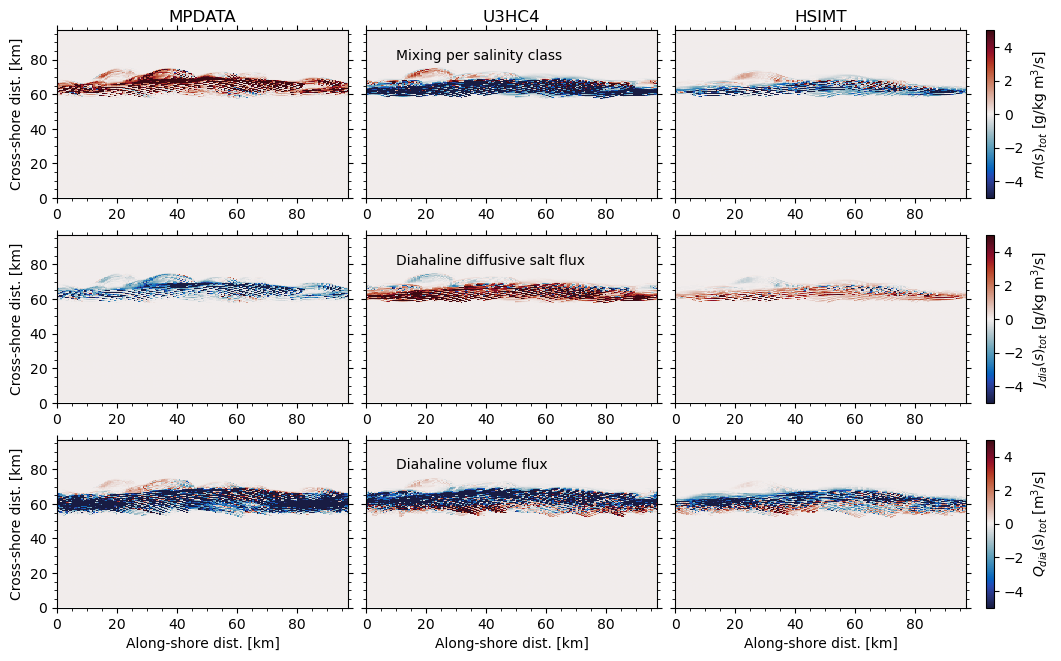

In [19]:
xrho = ds[0].x_rho.isel(eta_rho = slice(1,-1))/1000
yrho = ds[0].y_rho.isel(eta_rho = slice(1,-1))/1000

fig, ax = plt.subplots(3,3, figsize = ((7/2)*3,(8.66/4)*3), constrained_layout=True)

ax[0,0].pcolormesh(xrho, yrho, mpd_l.mtot.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
ax[0,1].pcolormesh(xrho, yrho, u3h_l.mtot.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
m = ax[0,2].pcolormesh(xrho, yrho, hsi_l.mtot.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
fig.colorbar(m, ax = ax[0,2], label = '$m(s)_{tot}$ [g/kg m$^3$/s]')

ax[1,0].pcolormesh(xrho, yrho, mpd_l.jdia_mtot.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
ax[1,1].pcolormesh(xrho, yrho, u3h_l.jdia_mtot.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
m1 = ax[1,2].pcolormesh(xrho, yrho, hsi_l.jdia_mtot.sum('salt_bin'), cmap=cmo.balance, vmin = -5, vmax = 5)
fig.colorbar(m, ax = ax[1,2], label = '$J_{dia}(s)_{tot}$ [g/kg m$^3$/s]')

ax[2,0].pcolormesh(xrho, yrho, mpd_l.Qdia_tot.sum('salt_bin'), cmap=cmo.balance, vmin = -50, vmax = 50)
ax[2,1].pcolormesh(xrho, yrho, u3h_l.Qdia_tot.sum('salt_bin'), cmap=cmo.balance, vmin = -50, vmax = 50)
m2 = ax[2,2].pcolormesh(xrho, yrho, hsi_l.Qdia_tot.sum('salt_bin'), cmap=cmo.balance, vmin = -50, vmax = 50)
fig.colorbar(m, ax = ax[2,2], label = '$Q_{dia}(s)_{tot}$ [m$^3$/s]')

ax[0,0].set_title('MPDATA')
ax[0,1].set_title('U3HC4')
ax[0,2].set_title('HSIMT')

# ax[0,0].text(10,80,'HSIMT')
ax[0,1].text(10,80,'Mixing per salinity class')
ax[1,1].text(10,80,'Diahaline diffusive salt flux')
ax[2,1].text(10,80,'Diahaline volume flux')

for i in range(3):
    for j in range(3):
        ax[i,j].set(xlim=[0,97], ylim=[0,97])
        ax[i,0].set_ylabel('Cross-shore dist. [km]')
        ax[2,j].set_xlabel('Along-shore dist. [km]')
        ax[i,1].set_yticklabels([])
        ax[i,2].set_yticklabels([])
        # ax[i,3].set_yticklabels([])
        ax[i,j].set_xticks(np.arange(0,100,20))
        ax[i,j].minorticks_on()
        ax[i,j].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
        ax[i,j].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)

# Plot the volume of each water for each isohaline 

In [20]:
sbins = np.arange(26.9,35.1,0.2) # Redefine them 
vhist = []
start = time.time()
for i in range(len(paths)):
    #Slice salinity and dV for histograms
    salt = ds[i].salt.isel(ocean_time = tslice, xi_rho = slice(1,-1), eta_rho = slice(1,-1)).where(ds[i].z_rho>-1)
    salt = salt.fillna(0) #fill nans 
    salt.attrs = ''
    salt.name = 'salt'
    
    dV = ds[i].dV.isel(ocean_time = tslice, xi_rho = slice(1,-1), eta_rho = slice(1,-1)).where(ds[i].z_rho>-1)
    dV = dV.fillna(0)
    dV.attrs = ''
    
    vhist1 = histogram(salt, bins = [sbins], weights = dV, dim = ['s_rho', 'eta_rho', 'xi_rho']) 
    vhist1.attrs = ''
    vhist1.name = 'dV'
    vhist.append(vhist1.load())
    
    elap_time = (time.time() - start) 
    print('Iter. complete in sec.', elap_time)

Iter. complete in sec. 20.683279514312744
Iter. complete in sec. 40.795698165893555
Iter. complete in sec. 60.51404690742493


### Computation is slow.
Likely ```.fillna()``` that's the cause? Regardless, make salinity space plots of the volumes and volume per salinity class 

Text(0.5, 1.0, 'Volume-weighted histogram of salinity')

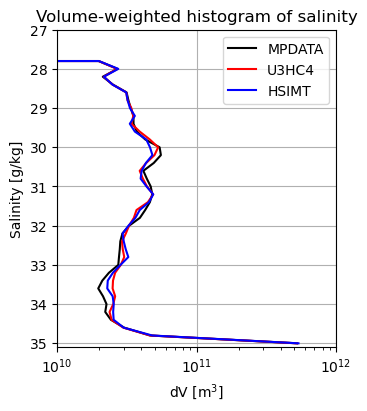

In [21]:
fig, ax = plt.subplots(1,1, figsize = (3.5*1,4), sharex = True, sharey= True, constrained_layout = True)

plt.semilogx(vhist[0].sum('ocean_time'), vhist[0].salt_bin, c = 'k', label = r'MPDATA')
plt.semilogx(vhist[1].sum('ocean_time'), vhist[0].salt_bin, c = 'r', label = r'U3HC4')
plt.semilogx(vhist[2].sum('ocean_time'), vhist[0].salt_bin, c = 'b', label = r'HSIMT')
plt.gca().invert_yaxis()
plt.grid()
plt.xlim(1e10, 1e12)
plt.ylim(35.1,27)
plt.legend()
plt.xlabel(r'dV [m$^3$]')
plt.ylabel(r'Salinity [g/kg]')
plt.title('Volume-weighted histogram of salinity')

### Now plot a time series. 
Try out the following plots:
> - Plot just a time series by summing over the salinity axis. This will tell us the bulk differences betweeen the the total volume in each isohaline 
> - How to slice each isohaline? The values will be partially determined by the number of bins
> > - Maybe integrate over a discrete range, like integrate over the 27-28 salinity range and plot those values? Try both

In [22]:
time = np.arange(0,len(vhist[0].ocean_time))/24 #Crude time vector, could do this a fancier way but meh. 
time+=7.5# define time vector for plotting 

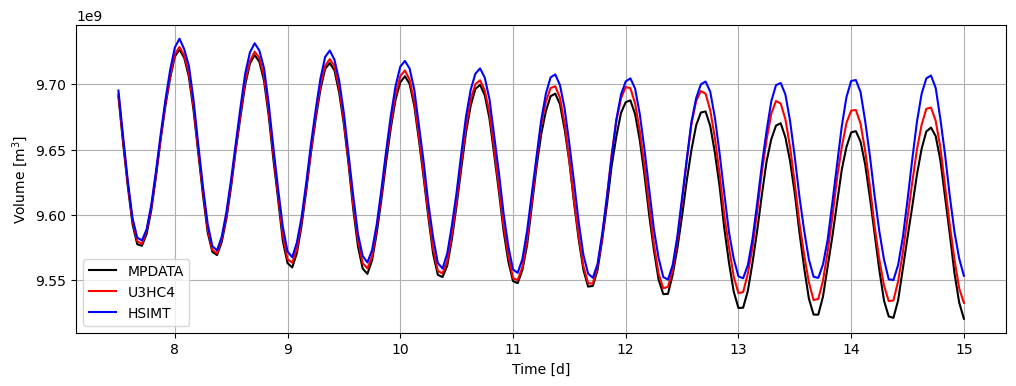

In [23]:
fig, ax = plt.subplots(1, figsize = (12,4))

plt.plot(time, vhist[0].sum('salt_bin'), c = 'k', label = 'MPDATA')
plt.plot(time, vhist[1].sum('salt_bin'), c = 'r', label = 'U3HC4')
plt.plot(time, vhist[2].sum('salt_bin'), c = 'b', label = 'HSIMT')
plt.grid()
plt.xlabel('Time [d]')
plt.ylabel('Volume [m$^3$]')
plt.legend()

Text(0.5, 0, 'Time [d]')

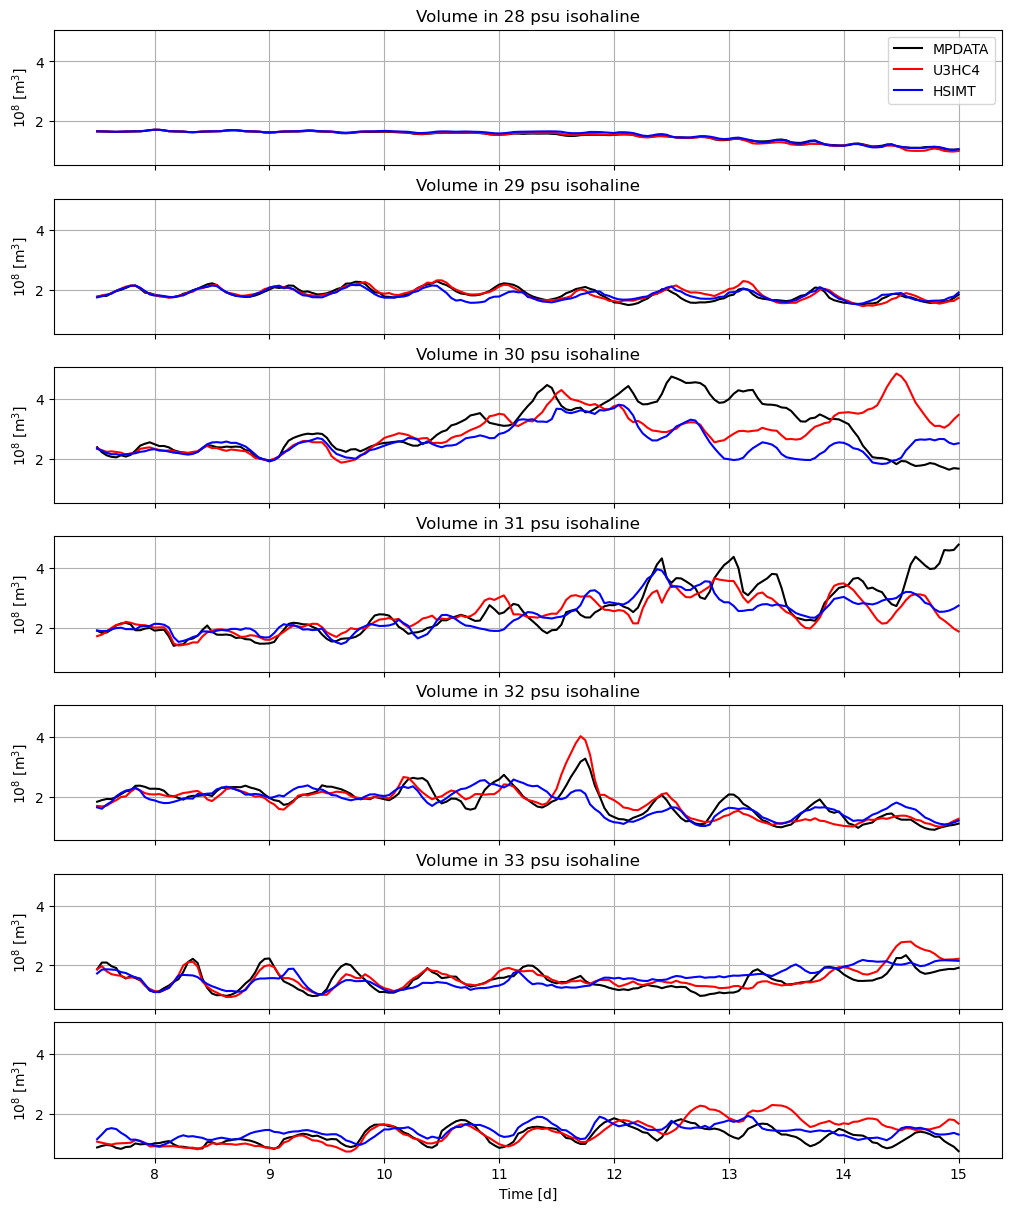

In [24]:
nrows = 7 ; ncols = 1
fig, ax = plt.subplots(nrows,ncols, figsize = (10,12), constrained_layout = True, sharey = True)

ax[0].plot(time, vhist[0].sel(salt_bin=28, method = 'nearest')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[0].plot(time, vhist[1].sel(salt_bin=28, method = 'nearest')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[0].plot(time, vhist[2].sel(salt_bin=28, method = 'nearest')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[1].plot(time, vhist[0].sel(salt_bin=29, method = 'nearest')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[1].plot(time, vhist[1].sel(salt_bin=29, method = 'nearest')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[1].plot(time, vhist[2].sel(salt_bin=29, method = 'nearest')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[2].plot(time, vhist[0].sel(salt_bin=30, method = 'nearest')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[2].plot(time, vhist[1].sel(salt_bin=30, method = 'nearest')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[2].plot(time, vhist[2].sel(salt_bin=30, method = 'nearest')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[3].plot(time, vhist[0].sel(salt_bin=31, method = 'nearest')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[3].plot(time, vhist[1].sel(salt_bin=31, method = 'nearest')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[3].plot(time, vhist[2].sel(salt_bin=31, method = 'nearest')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[4].plot(time, vhist[0].sel(salt_bin=32, method = 'nearest')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[4].plot(time, vhist[1].sel(salt_bin=32, method = 'nearest')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[4].plot(time, vhist[2].sel(salt_bin=32, method = 'nearest')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[5].plot(time, vhist[0].sel(salt_bin=33, method = 'nearest')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[5].plot(time, vhist[1].sel(salt_bin=33, method = 'nearest')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[5].plot(time, vhist[2].sel(salt_bin=33, method = 'nearest')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[6].plot(time, vhist[0].sel(salt_bin=34, method = 'nearest')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[6].plot(time, vhist[1].sel(salt_bin=34, method = 'nearest')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[6].plot(time, vhist[2].sel(salt_bin=34, method = 'nearest')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

for i in range(nrows):
    ax[i].grid()
    ax[i].set_ylabel(r'10$^8$ [m$^3$]')
    
for i in range(nrows-1):
    ax[i].set_xticklabels('')
    ax[i].set_title('Volume in ' + str(28+i) + ' psu isohaline')
    
ax[0].legend()
ax[-1].set_xlabel('Time [d]')

### Now repeat but try integrating over 1 psu intervals, which requires the volume per salinity class $\partial_s V$
In other words, $\int_{28}^{29} \partial_s V \, ds$? Or do we just want to use $V(s)$, do a ```.cumsum()``` without multiplying by dsalt?

In [25]:
dsalt = (vhist[0].salt_bin[1]-vhist[0].salt_bin[0]).values

Vs = []
for i in range(len(paths)):
    v_s = vhist[i].diff('salt_bin')/dsalt
    Vs.append(v_s)

Text(0.5, 1.0, 'Volume per salinity class')

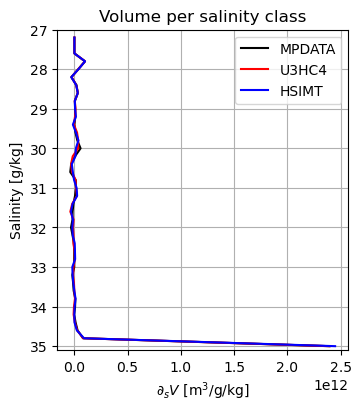

In [26]:
fig, ax = plt.subplots(1,1, figsize = (3.5*1,4), sharex = True, sharey= True, constrained_layout = True)

plt.plot(Vs[0].sum('ocean_time'), Vs[0].salt_bin, c = 'k', label = r'MPDATA')
plt.plot(Vs[1].sum('ocean_time'), Vs[0].salt_bin, c = 'r', label = r'U3HC4')
plt.plot(Vs[2].sum('ocean_time'), Vs[0].salt_bin, c = 'b', label = r'HSIMT')
plt.gca().invert_yaxis()
plt.grid()
# plt.xlim(1e10, 1e12)
plt.ylim(35.1,27)
plt.legend()
plt.xlabel(r'$\partial_s V$ [m$^3$/g/kg]')
plt.ylabel(r'Salinity [g/kg]')
plt.title('Volume per salinity class')

Text(0.5, 1.0, '|Volume per salinity class|')

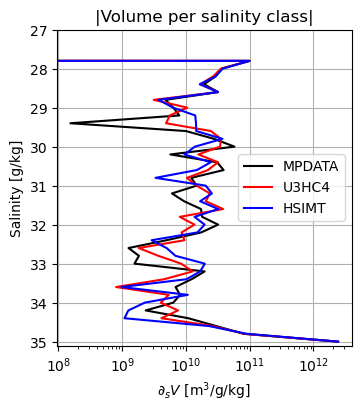

In [27]:
fig, ax = plt.subplots(1,1, figsize = (3.5*1,4), sharex = True, sharey= True, constrained_layout = True)

plt.semilogx(np.abs(Vs[0].sum('ocean_time')), Vs[0].salt_bin, c = 'k', label = r'MPDATA')
plt.semilogx(np.abs(Vs[1].sum('ocean_time')), Vs[0].salt_bin, c = 'r', label = r'U3HC4')
plt.semilogx(np.abs(Vs[2].sum('ocean_time')), Vs[0].salt_bin, c = 'b', label = r'HSIMT')
plt.gca().invert_yaxis()
plt.grid()
# plt.xlim(1e10, 1e12)
plt.ylim(35.1,27)
plt.legend()
plt.xlabel(r'$\partial_s V$ [m$^3$/g/kg]')
plt.ylabel(r'Salinity [g/kg]')
plt.title('|Volume per salinity class|')

### Now do the integration and plot. 
Quickly qc the calculation by comparing the reconstructed integral to actual volume 

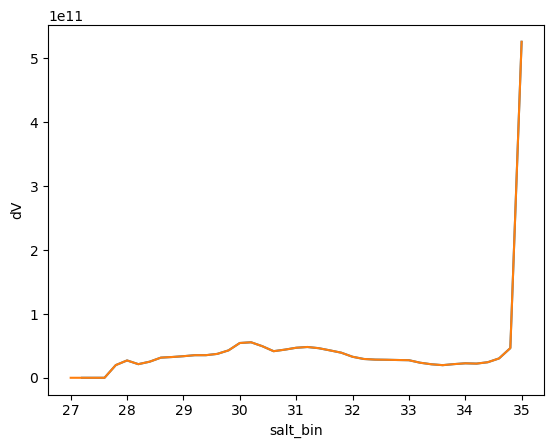

In [28]:
(Vs[0]*dsalt).cumsum('salt_bin').sum('ocean_time').plot()
vhist[0].sum('ocean_time').plot()

In [29]:
# Run the cell below to check that we're actually slicing the 27 to 18 psu bin
(Vs[0]*dsalt).sel(salt_bin = slice(27,28)) 

<xarray.DataArray 'dV' (ocean_time: 181, salt_bin: 5)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.12822801e+08,  5.33663950e+07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.09950719e+08,  5.59553918e+07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.08147920e+08,  5.73147318e+07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.07526955e+08,  5.71111662e+07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.07474164e+08,  5.67183052e+07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.07637780e+08,  5.71053344e+07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.08296361e+08,  5.71679759e+07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.10025064e+08,  5.58466469e+07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.12386370e+08,  5.37131457e+07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.13536994e+08,  5.28351776e+07],
...
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.11861990e+08, -7.52472415e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.12353224e+08, -1.47333159e+06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.12075895e+08,  1.29194180e+06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.10363487e+08,  3.50794805e+06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.08159081e+08,  5.65041446e+06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.07263041e+08,  4.51360886e+06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.07037311e+08,  1.80468972e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.06858834e+08, -2.11666733e+06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.06723228e+08, -1.68005315e+06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.06694042e+08, -1.40796856e+06]])
Coordinates:
  * ocean_time  (ocean_time) object 0001-01-07 12:30:00 ... 0001-01-15 00:30:00
  * salt_bin    (salt_bin) float64 27.2 27.4 27.6 27.8 28.0

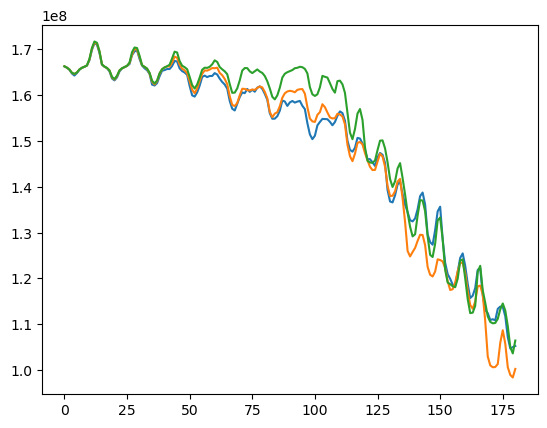

In [30]:
plt.plot((Vs[0]*dsalt).sel(salt_bin = slice(27,28)).sum('salt_bin'))
plt.plot((Vs[1]*dsalt).sel(salt_bin = slice(27,28)).sum('salt_bin'))
plt.plot((Vs[2]*dsalt).sel(salt_bin = slice(27,28)).sum('salt_bin'))

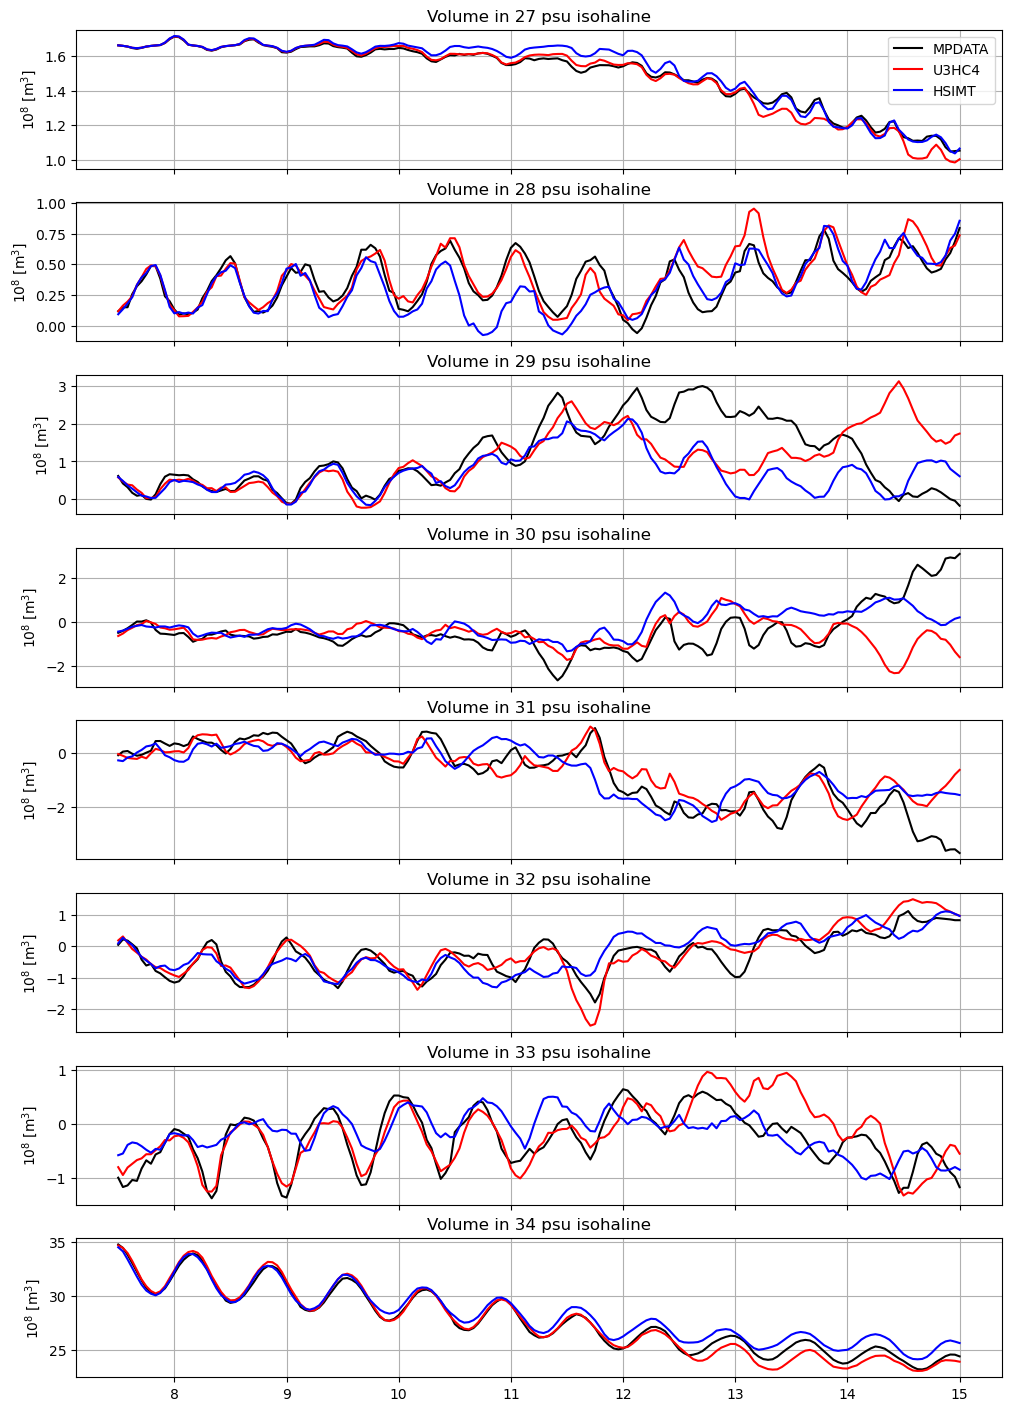

In [33]:
nrows = 8 ; ncols = 1
fig, ax = plt.subplots(nrows,ncols, figsize = (10,2*7), constrained_layout = True, sharey = False)

ax[0].plot(time, (Vs[0]*dsalt).sel(salt_bin = slice(27,28)).sum('salt_bin')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[0].plot(time, (Vs[1]*dsalt).sel(salt_bin = slice(27,28)).sum('salt_bin')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[0].plot(time, (Vs[2]*dsalt).sel(salt_bin = slice(27,28)).sum('salt_bin')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[1].plot(time, (Vs[0]*dsalt).sel(salt_bin = slice(28,29)).sum('salt_bin')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[1].plot(time, (Vs[1]*dsalt).sel(salt_bin = slice(28,29)).sum('salt_bin')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[1].plot(time, (Vs[2]*dsalt).sel(salt_bin = slice(28,29)).sum('salt_bin')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[2].plot(time, (Vs[0]*dsalt).sel(salt_bin = slice(29,30)).sum('salt_bin')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[2].plot(time, (Vs[1]*dsalt).sel(salt_bin = slice(29,30)).sum('salt_bin')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[2].plot(time, (Vs[2]*dsalt).sel(salt_bin = slice(29,30)).sum('salt_bin')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[3].plot(time, (Vs[0]*dsalt).sel(salt_bin = slice(30,31)).sum('salt_bin')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[3].plot(time, (Vs[1]*dsalt).sel(salt_bin = slice(30,31)).sum('salt_bin')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[3].plot(time, (Vs[2]*dsalt).sel(salt_bin = slice(30,31)).sum('salt_bin')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[4].plot(time, (Vs[0]*dsalt).sel(salt_bin = slice(31,32)).sum('salt_bin')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[4].plot(time, (Vs[1]*dsalt).sel(salt_bin = slice(31,32)).sum('salt_bin')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[4].plot(time, (Vs[2]*dsalt).sel(salt_bin = slice(31,32)).sum('salt_bin')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[5].plot(time, (Vs[0]*dsalt).sel(salt_bin = slice(32,33)).sum('salt_bin')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[5].plot(time, (Vs[1]*dsalt).sel(salt_bin = slice(32,33)).sum('salt_bin')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[5].plot(time, (Vs[2]*dsalt).sel(salt_bin = slice(32,33)).sum('salt_bin')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[6].plot(time, (Vs[0]*dsalt).sel(salt_bin = slice(33,34)).sum('salt_bin')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[6].plot(time, (Vs[1]*dsalt).sel(salt_bin = slice(33,34)).sum('salt_bin')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[6].plot(time, (Vs[2]*dsalt).sel(salt_bin = slice(33,34)).sum('salt_bin')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[7].plot(time, (Vs[0]*dsalt).sel(salt_bin = slice(34,35)).sum('salt_bin')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[7].plot(time, (Vs[1]*dsalt).sel(salt_bin = slice(34,35)).sum('salt_bin')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[7].plot(time, (Vs[2]*dsalt).sel(salt_bin = slice(34,35)).sum('salt_bin')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

for i in range(nrows):
    ax[i].grid()
    ax[i].set_ylabel(r'10$^8$ [m$^3$]')
    ax[i].set_title('Volume in ' + str(27+i) + ' psu isohaline')
    
for i in range(nrows-1):
    ax[i].set_xticklabels('')
    
ax[0].legend()

Text(0.5, 0, 'Time [d]')

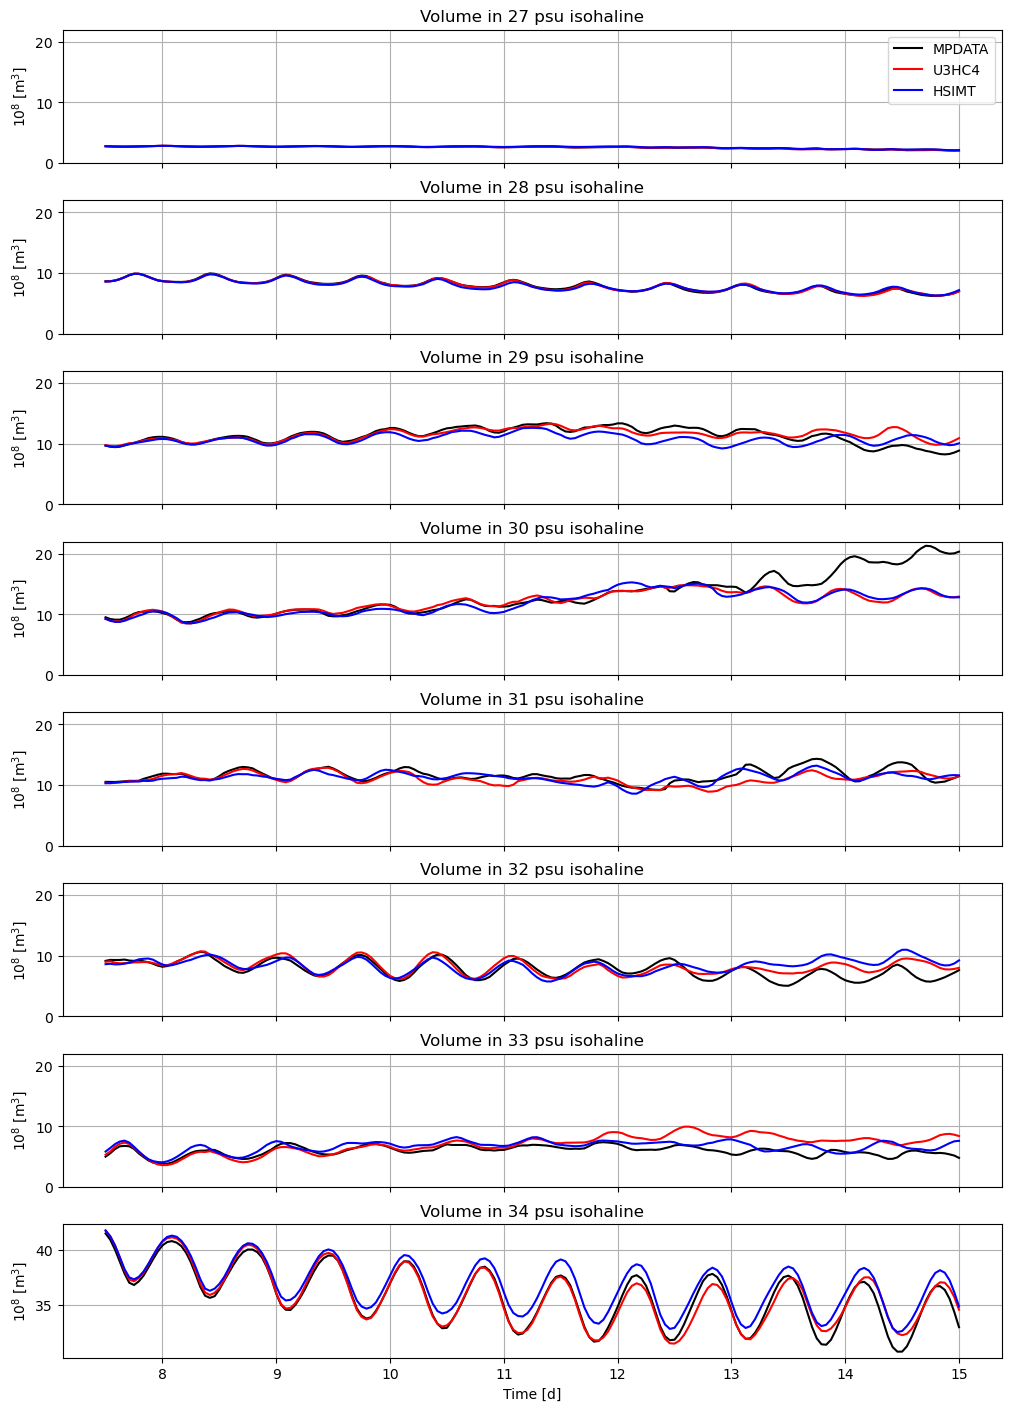

In [61]:
nrows = 8 ; ncols = 1
fig, ax = plt.subplots(nrows,ncols, figsize = (10,2*7), constrained_layout = True, sharey = False)

ax[0].plot(time, ((vhist[0]).sel(salt_bin = slice(27,28)).sum('salt_bin'))/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[0].plot(time, ((vhist[1]).sel(salt_bin = slice(27,28)).sum('salt_bin'))/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[0].plot(time, ((vhist[2]).sel(salt_bin = slice(27,28)).sum('salt_bin'))/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[1].plot(time, ((vhist[0]).sel(salt_bin = slice(28,29)).sum('salt_bin'))/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[1].plot(time, ((vhist[1]).sel(salt_bin = slice(28,29)).sum('salt_bin'))/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[1].plot(time, ((vhist[2]).sel(salt_bin = slice(28,29)).sum('salt_bin'))/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[2].plot(time, ((vhist[0]).sel(salt_bin = slice(29,30)).sum('salt_bin'))/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[2].plot(time, ((vhist[1]).sel(salt_bin = slice(29,30)).sum('salt_bin'))/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[2].plot(time, ((vhist[2]).sel(salt_bin = slice(29,30)).sum('salt_bin'))/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[3].plot(time, ((vhist[0]).sel(salt_bin = slice(30,31)).sum('salt_bin'))/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[3].plot(time, ((vhist[1]).sel(salt_bin = slice(30,31)).sum('salt_bin'))/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[3].plot(time, ((vhist[2]).sel(salt_bin = slice(30,31)).sum('salt_bin'))/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[4].plot(time, ((vhist[0]).sel(salt_bin = slice(31,32)).sum('salt_bin'))/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[4].plot(time, ((vhist[1]).sel(salt_bin = slice(31,32)).sum('salt_bin'))/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[4].plot(time, ((vhist[2]).sel(salt_bin = slice(31,32)).sum('salt_bin'))/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[5].plot(time, ((vhist[0]).sel(salt_bin = slice(32,33)).sum('salt_bin'))/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[5].plot(time, ((vhist[1]).sel(salt_bin = slice(32,33)).sum('salt_bin'))/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[5].plot(time, ((vhist[2]).sel(salt_bin = slice(32,33)).sum('salt_bin'))/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[6].plot(time, ((vhist[0]).sel(salt_bin = slice(33,34)).sum('salt_bin'))/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[6].plot(time, ((vhist[1]).sel(salt_bin = slice(33,34)).sum('salt_bin'))/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[6].plot(time, ((vhist[2]).sel(salt_bin = slice(33,34)).sum('salt_bin'))/10**8, c = 'b', lw = 1.5, label = 'HSIMT')


ax[7].plot(time, ((vhist[0]).sel(salt_bin = slice(34,35)).sum('salt_bin'))/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[7].plot(time, ((vhist[1]).sel(salt_bin = slice(34,35)).sum('salt_bin'))/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[7].plot(time, ((vhist[2]).sel(salt_bin = slice(34,35)).sum('salt_bin'))/10**8, c = 'b', lw = 1.5, label = 'HSIMT')
ax[7].get_shared_y_axes().remove(ax[7])

for i in range(nrows):
    ax[i].grid()
    ax[i].set_ylabel(r'10$^8$ [m$^3$]')
    ax[i].set_title('Volume in ' + str(27+i) + ' psu isohaline')
    
for i in range(nrows-1):
    ax[i].set_xticklabels('')
    
    ax[i].set_ylim(0,22)
    
ax[0].legend()
ax[-1].set_xlabel('Time [d]')

In [99]:
t = np.arange(0,len(vhist[0].ocean_time))/24
t+=7.5
S,T = np.meshgrid(vhist[0].salt_bin,t)
print(np.shape(T),np.shape(S),np.shape(vhist[0].T.values))

(181, 41) (181, 41) (41, 181)


# To do - label plots for meeting 

Text(0.5, 0, 'Time [d]')

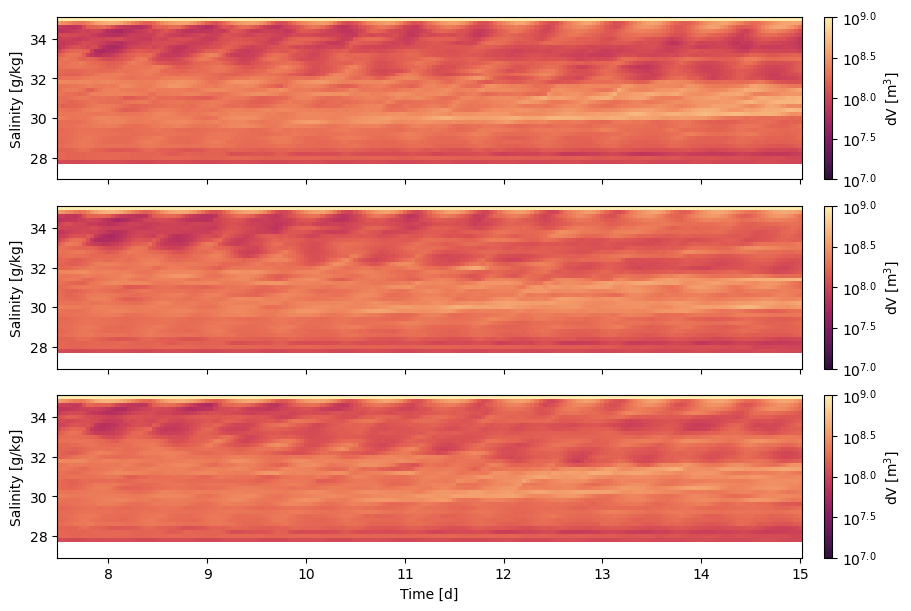

In [112]:
fig, ax = plt.subplots(3,1, figsize = (9,6), constrained_layout = True)

m = ax[0].pcolormesh(T, S, np.log10(vhist[0]), cmap = cmo.matter_r, vmin = 7, vmax = 9)
m1 = ax[1].pcolormesh(T, S, np.log10(vhist[1]), cmap = cmo.matter_r, vmin = 7, vmax = 9)
m2 = ax[2].pcolormesh(T, S, np.log10(vhist[2]), cmap = cmo.matter_r, vmin = 7, vmax = 9)
fig.colorbar(m, ax = ax[0], label = r'dV [m$^3$]', pad = 0.02, format = tick.FormatStrFormatter('$10^{%.1f}$'))
fig.colorbar(m1, ax = ax[1], label = r'dV [m$^3$]', pad = 0.02, format = tick.FormatStrFormatter('$10^{%.1f}$'))
fig.colorbar(m2, ax = ax[2], label = r'dV [m$^3$]', pad = 0.02, format = tick.FormatStrFormatter('$10^{%.1f}$'))

for i in range(3):
    ax[i].set_ylabel(r'Salinity [g/kg]')
    
for i in range(2):
    ax[i].set_xticklabels('')
    
ax[-1].set_xlabel('Time [d]')

Text(0.5, 0, 'Time [d]')

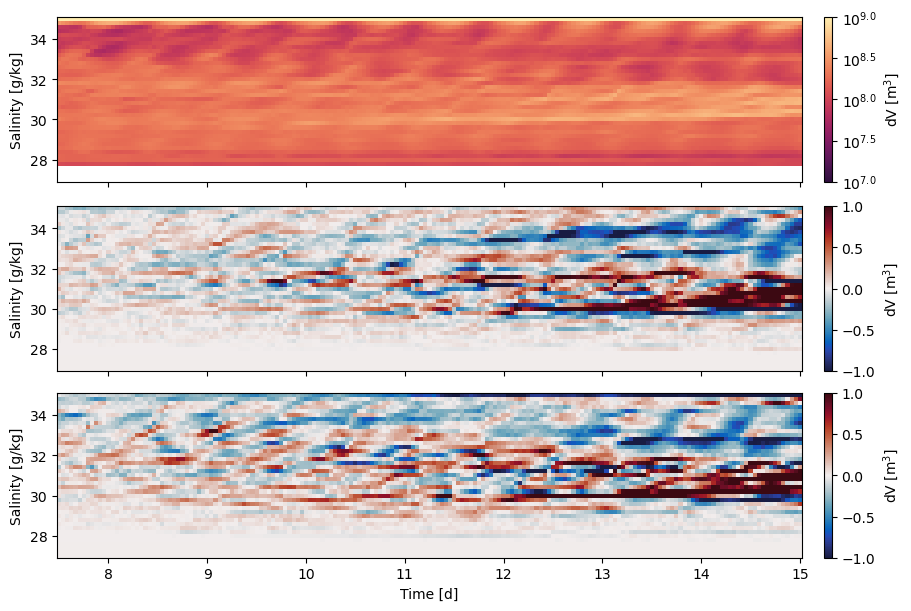

In [116]:
fig, ax = plt.subplots(3,1, figsize = (9,6), constrained_layout = True)

m = ax[0].pcolormesh(T, S, np.log10(vhist[0]), cmap = cmo.matter_r, vmin = 7, vmax = 9)
m1 = ax[1].pcolormesh(T, S, (vhist[0]-vhist[1])/1e8, cmap = cmo.balance, vmin = -1, vmax = 1)
m2 = ax[2].pcolormesh(T, S, (vhist[0]-vhist[2])/1e8, cmap = cmo.balance, vmin = -1, vmax = 1)
fig.colorbar(m, ax = ax[0], label = r'dV [m$^3$]', pad = 0.02, format = tick.FormatStrFormatter('$10^{%.1f}$'))
fig.colorbar(m1, ax = ax[1], label = r'dV [m$^3$]', pad = 0.02)
fig.colorbar(m2, ax = ax[2], label = r'dV [m$^3$]', pad = 0.02)

for i in range(3):
    ax[i].set_ylabel(r'Salinity [g/kg]')
    
for i in range(2):
    ax[i].set_xticklabels('')
    
ax[-1].set_xlabel('Time [d]')

ax